# Sentiment Analysis

This is my first project regarding NLP. The goal with this project is to learn how to perform Sentiment Analysis from scratch, and for that reason I will try to use as fewer libraries as possible.

The dataset that I will be using is the following from Kaggle: https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset/data

**IMPORTANT!**

If you dont want to execute the whole notebook but want to play with this, you can load the models using the last cell!


In [25]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from collections import defaultdict
import nltk
nltk.download('stopwords')

# let pandas write the whole sentence
pd.set_option('display.max_colwidth', 1000)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# load the dataset
filename = "kaggle/input/spotify-dataset/DATASET.csv"
df = pd.read_csv(filename)
print(df.shape)
df.head(10)

(52702, 2)


,Review,label
0,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",POSITIVE
1,Please ignore previous negative rating. This app is super great. I give it five stars+,POSITIVE
2,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,NEGATIVE
5,The player controls sometimes disappear for no reason. App restart forgets what I was playing but fixes the issue.,NEGATIVE
6,I love the selection and the lyrics are provided with the song you're listening to!,POSITIVE
7,"Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done NOTHING to solve it! Over time I have changed sd cards, each being faster in read, write speeds(all samsung brand). And please add ""don't like song"" so it will never appear again in my searches or playlists.",NEGATIVE
8,"It's a great app and the best mp3 music app I have ever used but there is one problem that, why can't we play some songs or find some songs? despite this the app is wonderful I recommend it. it's just the best.",POSITIVE
9,"I'm deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consumer doesn't want to pay for music they can't fully own, and 6 ads successively, upon logging in, before a single song, is too much. Closed the app during ad number 6, and I'm more patient than most. If those are the only ways you can profit: you've already peaked. All that's left is your decline.",NEGATIVE


## Preprocessing

After loading the dataset, we should do some preprocessing. The first thing that we are going to do is some general EDA and then proceed to process the text.

### EDA




In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52702 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  52686 non-null  object
 1   label   52702 non-null  object
dtypes: object(2)
memory usage: 823.6+ KB


Lets check for missing and duplicated values

In [28]:
print("Null:")
df.isnull().sum()


Null:


Review    16
label      0
dtype: int64

In [29]:
print("Duplicate:")
df.duplicated().sum()

Duplicate:


1229

We can see that there are 16 null entries, but also 1229 duplicated ones. We are going to drop them.

In [30]:
df = df.dropna()
df = df.drop_duplicates()

Lets check with a plot how the classes are distributed:

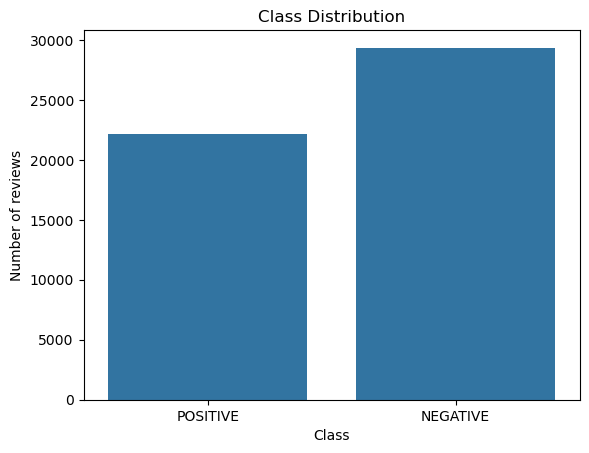

In [31]:
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xlabel("Class")
plt.ylabel("Number of reviews")
plt.show()

We can see a higher number of negative reviews, but nonetheless, the difference is not drastic.

After this, we can start preprocessing the text. Although there exists libraries that could do this for us such as `NLTK` or `TextBlob`, I'm going to do it manually.

We are going to perform the following:

- Clean the text
- Tokenize
- Remove stopwords
- Lemmatization/Stemming

### Clean the text

The process is going to be like this:
1. Convert slangs like ASAP into As Soon As Possible
2. Turn everything to lowercase
3. Remove punctuations, html tags, accents and so on, if it was in another language like spanish i would convert the accents into their non-accent version, e.g. á would be a, but since it is in english I will delete them.

In [32]:
# source: https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt

abbreviations = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My Ass Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My Ass Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The Fuck",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don’t care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can’t stop laughing"
}

def replace_abbreviation(text):
    # if the abbreviation is not found, the word is added as is
    result = [abbreviations.get(word.upper(), word) for word in text.split()]
    # join the list
    return " ".join(result)

example = "AFAIK Spotify is an app, CU"
print("Example:\n" + example)
print("Result:\n" + replace_abbreviation(example))

df['Review'] = df['Review'].apply(lambda x: replace_abbreviation(x))


Example:
AFAIK Spotify is an app, CU
Result:
As Far As I Know Spotify is an app, See You


In [33]:
# lowercase
print("Before:\n" + df.iloc[0]['Review'])
df['Review'] = df['Review'].apply(lambda x: x.lower())
print("After:\n" + df.iloc[0]['Review'])

Before:
Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.
After:
great music service, the audio is high quality and the app is easy to use. also very quick and friendly support.


In [34]:
# remove punctuations, brackets, <html>, etc.
print("Chars to remove: " + string.punctuation)

def remove_punctuation(sentence):
    # make a list with the chars that are not punctuation
    no_punct = [char for char in sentence if char not in string.punctuation]
    # print(no_punct)
    # join the list into a string
    no_punct = ''.join(no_punct)
    return no_punct

print("\nBefore:\n" + df.iloc[1]['Review'])
df['Review'] = df['Review'].apply(lambda x: remove_punctuation(x))
print("\nAfter:\n" + df.iloc[1]['Review'])

Chars to remove: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

Before:
please ignore previous negative rating. this app is super great. i give it five stars+

After:
please ignore previous negative rating this app is super great i give it five stars


This next cell could replace the previous one since what im going to do is to replace all characters that are not a-z, number or a space with a blank, so it would also get rid of punctuation, but just for the sake of showing 2 alternatives I'll do it again. Also I will look if there is cases with more than one blank space and remove them.

In [35]:
# remove special characters, like accents


def clean_text(sentence):
    pattern = r"[^a-zA-Z0-9\s]"
    clean = re.sub(pattern, "", sentence)
    spaces_pattern = r"\s+"
    return re.sub(spaces_pattern, " ", clean).lower()

In [36]:
sentence = "exampl3 of a     sentence!,,,"

print("Before:\n" + sentence)
print("After:\n" + clean_text(sentence))

df['Review'] = df['Review'].apply(lambda x: clean_text(x))

Before:
exampl3 of a     sentence!,,,
After:
exampl3 of a sentence


### Tokenization

Since we have already removed everything but the letters and numbers and made sure that each word is separated with just one blank space, we can make use of the `.split()` method in python to tokenize the string without needing any other library

In [37]:
def tokenize_text(text):
    return text.split()

print("Before:\n" + df.iloc[0]['Review'])

df['Review'] = df['Review'].apply(lambda x: tokenize_text(x))

print("After:")
print(df.iloc[0]['Review'])


Before:
great music service the audio is high quality and the app is easy to use also very quick and friendly support
After:
['great', 'music', 'service', 'the', 'audio', 'is', 'high', 'quality', 'and', 'the', 'app', 'is', 'easy', 'to', 'use', 'also', 'very', 'quick', 'and', 'friendly', 'support']


### Stop words

The next step is to remove the stop words from the tokenization, these are the words that are not adding a lot of meaning to the sentence.

For example, in the previous sentence, "the audio is high quality and the app is easy to use", could just be something like "audio high quality app easy use" and we would reduce the sentence while maintaining the meaning.

To do this we will use the set of stop words from `nltk`.

In [38]:
def remove_stopwords(words):
    stop_words = stopwords.words('english')
    result = [word for word in words if word not in stop_words]
    return result

print("Before:")
print(df.iloc[0]['Review'])
df['Review'] = df['Review'].apply(lambda x: remove_stopwords(x))
print("After")
print(df.iloc[0]['Review'])


Before:
['great', 'music', 'service', 'the', 'audio', 'is', 'high', 'quality', 'and', 'the', 'app', 'is', 'easy', 'to', 'use', 'also', 'very', 'quick', 'and', 'friendly', 'support']
After
['great', 'music', 'service', 'audio', 'high', 'quality', 'app', 'easy', 'use', 'also', 'quick', 'friendly', 'support']


### Stemming and Lemmatization

These are different techniques, stemming is getting the root of a word like for example from "working" get "work", this can be done by removing the suffix "-ing", the problem with this that for example words like "ring" would get to be "r".

On the other hand Lemmatization returns the words to its *lemma* or dictionary form, for example "working" would be "work", but "ring" would remain the same, or "ate" would be "eat".

Although the second is more accurate and can be done with libraries like `nltk`, since I want to use as little libraries as possible, I will do it manually removing suffix such as "-ing", "-ly", "-s", "-es".

I will also address errors like `running` -> `runn` by removing double consonants at the end, or handle finishing `i`, like in `flies` -> `fli`, or `ring` -> `r` by making sure that no word gets a length of 2 or sorter (I chose this length because I can't think of any word that is 2 character long and is not a stopword).

e.g.

`[app, working, slowly]` -> `[app, work, slow]`

In [39]:
def basic_stemmer(words):
    stemmed_words = []
    for word in words:
        # Save original to be able to revert
        original = word
        # Rules to remove common suffixes
        word = re.sub(r'ing$', '', word)
        word = re.sub(r'ed$', '', word)
        word = re.sub(r'es$', '', word)
        word = re.sub(r's$', '', word)
        word = re.sub(r'ly$', '', word)
        word = re.sub(r'ment$', '', word)
        word = re.sub(r'able$', '', word)
        word = re.sub(r'ful$', '', word)
        word = re.sub(r'ness$', '', word)

        # flies -> fly
        if word[-1:] == 'i':
            word = word[:-1] + 'y'

        # running -> run
        if len(word) > 1 and word[-1] == word[-2] and word[-1] not in 'aeiou':
            word = word[:-1]

        if len(word) <= 2:
            word = original

        stemmed_words.append(word)

    return stemmed_words

In [40]:
words = ["running", "flies", "eating", "agreeable", "ring"]
stemmed_words = basic_stemmer(words)
print(f"Original words: {words}")
print(f"Stemmed words: {stemmed_words}")

df['Review'] = df['Review'].apply(lambda x: basic_stemmer(x))


Original words: ['running', 'flies', 'eating', 'agreeable', 'ring']
Stemmed words: ['run', 'fly', 'eat', 'agree', 'ring']


## Creating the model (unique IDs model)

There are different techniques to turn the words into numerical values:
- **Bag of Words:** Creates a DataFrame with all the words,and then for each sentence adds the number of times that word appears (or even just a `1` if it appears and a `0` if it doesn't), order doesn't matter.
- **TF-IDF:** Similar to Bag of Words, but instead of the count it computes TF (Term Frequency) measures how often a word appears in a document, and IDF (Inverse Document Frequency) measures how rare the word is across all documents. 
- **Word2Vec:** Creates a vector embedding for each word where words with related have closer vectors. This is done using neural networks.
- **GloVe:** Global Vectors for Word Representation, it is similar to Word2Vec, where words get vector embedding. The main difference is that take the global context more into account.

But since the goal is to learn more, I will do a simple approach like in the [TensorFlow series in NLP](https://www.youtube.com/watch?v=fNxaJsNG3-s&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S) and turn each word into a number, then reserve the `1` for Out Of Vocabulary and use the `0` for padding.

### Test-Train Split

Lets do a test-train split now, leaving 20% of the dataset for later usage.

We will also convert the `label` to a numerical value, `POSITIVE` will be 1 while `NEGATIVE` will be 0.

In [41]:
df['label'] = df['label'].map({'POSITIVE': 1, 'NEGATIVE': 0})

X = df['Review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (41177,) (41177,)
Testing set shape: (10295,) (10295,)


### Embedding

Now following the approach I mentioned before I will assign a number for each word, this is why it was important to perform stemming, so that words like `running`, `runs` and `run` get the same ID because they come from the same.

To create this, I will make a set with all the words (this way I avoid duplicated words), and then assign one number or ID to each word, starting at `2` to reserve `1` for OOV and `0` for padding. This will of course be only done with the training set. That is why we have the Out Of Vocabulary, which is reserved, for the case that during testing we have to convert a word into number and there is no ID for that word.

In [42]:
def create_word_to_id(texts):
    all_words = set()
    for text in texts:
        # With update I can do all the list
        all_words.update(text)

    # Create the dictionary
    word_to_id = {word: i+2 for i, word in enumerate(all_words)}

    word_to_id["<PAD>"] = 0
    word_to_id["<OOV>"] = 1

    return word_to_id


def sentence_to_ids(sentence, word_to_id):
    # converts the sentence to a list of numbers, if a word is not in the dict, it gets 1 (<OOV>)
    return [word_to_id.get(word, word_to_id["<OOV>"]) for word in sentence]

word_to_id = create_word_to_id(X_train)

print("Before")
print(X_train[0])

X_train = X_train.apply(lambda sentence: sentence_to_ids(sentence, word_to_id))
X_test = X_test.apply(lambda sentence: sentence_to_ids(sentence, word_to_id))

print("After")
print(X_train[0])


Before
['great', 'music', 'service', 'audio', 'high', 'quality', 'app', 'easy', 'use', 'also', 'quick', 'friend', 'support']
After
[8013, 18436, 13337, 17454, 5776, 8681, 18346, 4045, 31, 7170, 16297, 883, 5162]


Now we should define a length for the sentences, that means we should add some padding to some sentences while others should get truncated

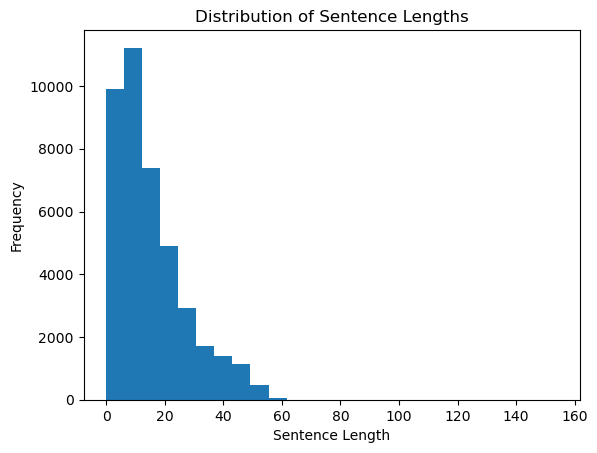

Max length: 154


In [43]:
lengths = [len(text) for text in X_train]
plt.hist(lengths, bins=25)
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths")
plt.show()

print(f'Max length: {max(lengths)}')

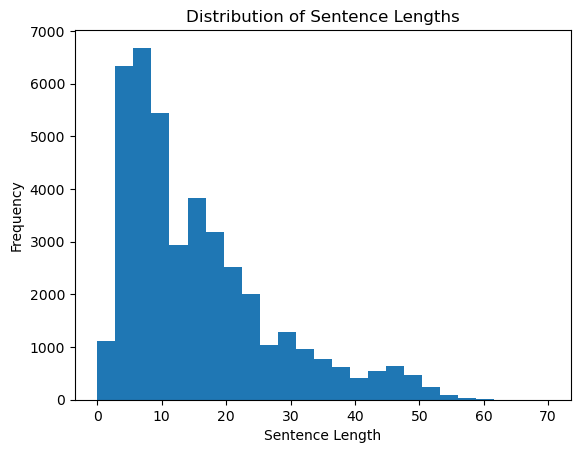

In [44]:
plt.hist(lengths, bins=25, range=(0, 70))
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths")
plt.show()


After these plots and having seen that the max length is 154, we can see that most of the sentences are in the 0-25 range, so that's the maximum length I will take, that means that longer ones will get truncated and shorted ones will be padded.

In [45]:
def pad_and_truncate(sentence, word_to_id, max_length):
    if len(sentence) < max_length:
        padding_length = max_length - len(sentence)
        sentence += [word_to_id["<PAD>"]] * padding_length
    else:
        sentence = sentence[:max_length]

    return sentence

# Example usage:
max_length = 25
print("Before\n")
print(X_train[0])
X_train = X_train.apply(lambda x: pad_and_truncate(x, word_to_id, max_length))
X_test =  X_test.apply(lambda x: pad_and_truncate(x, word_to_id, max_length))
print("After\n")
print(X_train[0])

Before

[8013, 18436, 13337, 17454, 5776, 8681, 18346, 4045, 31, 7170, 16297, 883, 5162]
After

[8013, 18436, 13337, 17454, 5776, 8681, 18346, 4045, 31, 7170, 16297, 883, 5162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Now we can finally create the model. I'm going to use `TensorFlow` for this. I will not use the embedding layers since the fun here is that I did my own embedding to see how well this can work.

The key things to create the model is that we have to make the input layer size the same as the maximum length, and also that we have to make it work for binary classification

In [46]:
model_ids = tf.keras.Sequential([
    # Input layer max_length, thats why the padding and truncate
    layers.Input(shape=(max_length,)),
    # Hidden layer
    layers.Dense(64, activation='relu'),
    # Dropout deactivates some neurons each time to avoid overfitting
    layers.Dropout(0.2),
    # Second hidden layer
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    # Binary
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_ids.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

X_train_tensor = tf.convert_to_tensor(X_train.tolist())
X_test_tensor = tf.convert_to_tensor(X_test.tolist())

# Train the model
history = model_ids.fit(X_train_tensor, y_train, epochs=25, validation_data=(X_test_tensor, y_test), batch_size=32)

# Test
test_loss, test_acc = model_ids.evaluate(X_test_tensor, y_test)


# Print the model summary
model_ids.summary()

Epoch 1/25
1287/1287 [==============================] - 5s 3ms/step - loss: 78.3960 - accuracy: 0.5539 - val_loss: 0.6837 - val_accuracy: 0.5703
Epoch 2/25
1287/1287 [==============================] - 3s 2ms/step - loss: 1.0696 - accuracy: 0.5717 - val_loss: 0.6830 - val_accuracy: 0.5694
Epoch 3/25
1287/1287 [==============================] - 4s 3ms/step - loss: 0.7920 - accuracy: 0.5724 - val_loss: 0.6835 - val_accuracy: 0.5694
Epoch 4/25
1287/1287 [==============================] - 3s 3ms/step - loss: 0.7625 - accuracy: 0.5706 - val_loss: 0.6835 - val_accuracy: 0.5695
Epoch 5/25
1287/1287 [==============================] - 3s 2ms/step - loss: 0.7054 - accuracy: 0.5720 - val_loss: 0.6836 - val_accuracy: 0.5695
Epoch 6/25
1287/1287 [==============================] - 3s 3ms/step - loss: 0.6972 - accuracy: 0.5719 - val_loss: 0.6793 - val_accuracy: 0.5763
Epoch 7/25
1287/1287 [==============================] - 3s 3ms/step - loss: 0.6912 - accuracy: 0.5743 - val_loss: 0.6787 - val_accuracy

In [47]:
sentences = [
    "I think the spotify application is super bad, I don't like it at all, there is no worse application + all the time with the suffle",
    "Spotify is my favourite app!! I love it, it is the best!!",
    "Spotify is okay, I guess. It's not great, but it's not terrible either.",
    "I'm really frustrated with Spotify's customer service. They were unhelpful and rude.",
    "The music selection on Spotify is amazing. I always find something new to listen to.",
    "I've been having issues with Spotify lately. It keeps crashing on my phone.",
    "Overall, I'm pretty happy with Spotify. It's a good value for the price.",
    "I hate Spotify and would never use this piece of junk!",
    "I canceled Spotify today, after 2 years of using it with no problems and great enjoyment. Now it's too restrictive and has little of the music I search for. Too bad, it was great while it was great!"
]

def preprocess_sentences(sentences):
    mod_sentences = [replace_abbreviation(sentence) for sentence in sentences]
    mod_sentences = [clean_text(sentence) for sentence in mod_sentences]
    mod_sentences = [tokenize_text(sentence) for sentence in mod_sentences]
    mod_sentences = [remove_stopwords(sentence) for sentence in mod_sentences]
    mod_sentences = [basic_stemmer(sentence) for sentence in mod_sentences]
    return mod_sentences

def convert_to_ids_model(mod_sentences, word_to_id, max_length):
    mod_sentences = [sentence_to_ids(sentence, word_to_id) for sentence in mod_sentences]
    mod_sentences = [pad_and_truncate(sentence, word_to_id, max_length) for sentence in mod_sentences]

    return mod_sentences

mod_sentences = preprocess_sentences(sentences)
mod_sentences = convert_to_ids_model(mod_sentences, word_to_id, max_length)

sentences_tensor = tf.convert_to_tensor(mod_sentences)

predictions = model_ids.predict(sentences_tensor)

for i, sentence in enumerate(sentences):
    print(f'{sentence}\n{predictions[i]}\n')


1/1 [==============================] - 0s 152ms/step
I think the spotify application is super bad, I don't like it at all, there is no worse application + all the time with the suffle
[0.43094906]

Spotify is my favourite app!! I love it, it is the best!!
[0.43094906]

Spotify is okay, I guess. It's not great, but it's not terrible either.
[0.43094906]

I'm really frustrated with Spotify's customer service. They were unhelpful and rude.
[0.43094906]

The music selection on Spotify is amazing. I always find something new to listen to.
[0.43094906]

I've been having issues with Spotify lately. It keeps crashing on my phone.
[0.43094906]

Overall, I'm pretty happy with Spotify. It's a good value for the price.
[0.43094906]

I hate Spotify and would never use this piece of junk!
[0.43094906]

I canceled Spotify today, after 2 years of using it with no problems and great enjoyment. Now it's too restrictive and has little of the music I search for. Too bad, it was great while it was great!
[

Sadly, we can see that this approach didn't work really well.

This is probably caused because the way we are doing it now is to just give a random ID to a word and then feed it to a neural network, not even caring about the order. So if we feed the neural network with the word 'best' in the first position and then in another sentence in the last one, different neurons with different weights are going to see the word.

And also, the IDs are random, and maybe we have the word "best" with the ID 3410 and "worst" with 3412 so that would make the neural network think that this words are close.

The next approach that I will try is to make a big matrix with the number of times a word appears, this is also known as **Bag of Words (BoW)**.

## Creating the model (Baf of Words)

The preprocessing is going to stay as is since I don't think this was the source of the problem.

I will load the dataset again just to avoid possible errors.

### Preprocessing

In [48]:
# load the dataset
df = pd.read_csv(filename)
print(df.head())

# drop duplicates and na
df = df.dropna()
df = df.drop_duplicates()

# replace abbreviations
df['Review'] = df['Review'].apply(lambda x: replace_abbreviation(x))
# remove punctuations, spaces, etc.
df['Review'] = df['Review'].apply(lambda x: clean_text(x))
# convert into a list of words
df['Review'] = df['Review'].apply(lambda x: tokenize_text(x))
# remove stopwords
df['Review'] = df['Review'].apply(lambda x: remove_stopwords(x))
# stemming
df['Review'] = df['Review'].apply(lambda x: basic_stemmer(x))
# convert label into 1 and 0
df['label'] = df['label'].map({'POSITIVE': 1, 'NEGATIVE': 0})


# train and testing split
X = df['Review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train[0])

                                                                                                             Review  \
0  Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.   
1                            Please ignore previous negative rating. This app is super great. I give it five stars+   
2        This pop-up "Get the best Spotify experience on Android 12" is too annoying. Please let's get rid of this.   
3                                                                   Really buggy and terrible to use as of recently   
4              Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?   

      label  
0  POSITIVE  
1  POSITIVE  
2  NEGATIVE  
3  NEGATIVE  
4  NEGATIVE  
['great', 'music', 'service', 'audio', 'high', 'quality', 'app', 'easy', 'use', 'also', 'quick', 'friend', 'support']


After doing the same preprocessing as before, we are ready to create the BoW.

I already did the train and test split since we should create the bag of words without seeing which ones we are going to test.

The first step to make the bag of words is going to do a set with all the words.

In [49]:
def create_vocabulary(texts):
    all_words = set()
    for text in texts:
        # With update I can do all the list
        all_words.update(text)

    return list(all_words)

def create_bow(sentences, vocab):
     # Create a word-to-index mapping for the vocabulary, like in the previous method
    word_to_index = {word: i for i, word in enumerate(vocab)}

    # Initialize the Bag of Words matrix (rows: sentences, columns: vocab size)
    bow_matrix = np.zeros((len(sentences), len(vocab)))

    # Fill the matrix
    for i, sentence in enumerate(sentences):
        word_counts = defaultdict(int)
        for word in sentence:
            if word in word_to_index:
                word_counts[word] += 1

        for word, count in word_counts.items():
            bow_matrix[i, word_to_index[word]] = count

    return bow_matrix

vocab = create_vocabulary(X_train)
X_train_bow = create_bow(X_train, vocab)
X_test_bow = create_bow(X_test, vocab)


print("Vocabulary size:", len(vocab))
print("Training data shape (Bag of Words):", X_train_bow.shape)
print("Test data shape (Bag of Words):", X_test_bow.shape)

def print_bow_example(sentence_bow, vocab):
    print("Word : Count")
    for i, count in enumerate(sentence_bow):
        # this because if not it is just a lot of 0s
        if count > 0:
            print(f"{vocab[i]} :\t {int(count)}")


    return

sentence = ['spotify', 'bad', 'music']
print("\nExample sentence:\n" + str(sentence))
sentence_bow = create_bow([sentence], vocab)[0]
print("\nBoW of the sentence:")
print_bow_example(sentence_bow, vocab)

Vocabulary size: 18867
Training data shape (Bag of Words): (41177, 18867)
Test data shape (Bag of Words): (10295, 18867)

Example sentence:
['spotify', 'bad', 'music']

BoW of the sentence:
Word : Count
bad :	 1
spotify :	 1
music :	 1


Now that we have done our bag of words we have to create our model. I'm going to keep using `TensorFlow`.

The things that we have to take into account are more or less as with the previous model. We have to make it have as input layer the size of the vocabulary, so it is going to be a very big input layer since it is ~19,000 while in the previous model it was ~25. And also that the model works for binary classification.

In [52]:
input_dim = len(vocab)

model_bow = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_bow.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_bow.fit(X_train_bow, y_train,
                    # LOWER to 5 JUST TO SPEED UP
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test_bow, y_test))


test_loss, test_acc = model_bow.evaluate(X_test_bow, y_test)

model_bow.summary()


Epoch 1/20
1287/1287 [==============================] - 27s 19ms/step - loss: 0.3568 - accuracy: 0.8498 - val_loss: 0.2928 - val_accuracy: 0.8794
Epoch 2/20
1287/1287 [==============================] - 23s 18ms/step - loss: 0.2882 - accuracy: 0.8800 - val_loss: 0.2898 - val_accuracy: 0.8820
Epoch 3/20
1287/1287 [==============================] - 22s 17ms/step - loss: 0.2580 - accuracy: 0.8943 - val_loss: 0.2912 - val_accuracy: 0.8831
Epoch 4/20
1287/1287 [==============================] - 22s 17ms/step - loss: 0.2286 - accuracy: 0.9063 - val_loss: 0.3029 - val_accuracy: 0.8802
Epoch 5/20
1287/1287 [==============================] - 23s 18ms/step - loss: 0.1969 - accuracy: 0.9212 - val_loss: 0.3195 - val_accuracy: 0.8777
Epoch 6/20
1287/1287 [==============================] - 23s 18ms/step - loss: 0.1775 - accuracy: 0.9303 - val_loss: 0.3345 - val_accuracy: 0.8757
Epoch 7/20
1287/1287 [==============================] - 25s 19ms/step - loss: 0.1577 - accuracy: 0.9367 - val_loss: 0.3545 -

## Final Comparison Word to IDs vs Bag of Words

In [53]:
sentences = [
    "I think the spotify application is super bad, I don't like it at all, there is no worse application + all the time with the suffle",
    "Spotify is my favourite app!! I love it, it is the best!!",
    "Spotify is okay, I guess. It's not great, but it's not terrible either.",
    "I'm really frustrated with Spotify's customer service. They were unhelpful and rude.",
    "The music selection on Spotify is amazing. I always find something new to listen to.",
    "I've been having issues with Spotify lately. It keeps crashing on my phone.",
    "Overall, I'm pretty happy with Spotify. It's a good value for the price.",
    "I hate Spotify and would never use this piece of junk!",
    "I canceled Spotify today, after 2 years of using it with no problems and great enjoyment. Now it's too restrictive and has little of the music I search for. Too bad, it was great while it was great!"
]

def preprocess_sentences(sentences):
    mod_sentences = [replace_abbreviation(sentence) for sentence in sentences]
    mod_sentences = [clean_text(sentence) for sentence in mod_sentences]
    mod_sentences = [tokenize_text(sentence) for sentence in mod_sentences]
    mod_sentences = [remove_stopwords(sentence) for sentence in mod_sentences]
    mod_sentences = [basic_stemmer(sentence) for sentence in mod_sentences]
    return mod_sentences



pre_sentences = preprocess_sentences(sentences)
sentences_ids = convert_to_ids_model(pre_sentences, word_to_id, max_length)
sentences_bow = create_bow(pre_sentences, vocab)

sentences_tensor = tf.convert_to_tensor(sentences_ids)


predictions_bow = model_bow.predict(sentences_bow)
predictions_ids = model_ids.predict(sentences_tensor)




def display_sentence_predictions(sentences, predictions_bow, predictions_ids):
    data = []
    for i, sentence in enumerate(sentences):
        bow_score = predictions_bow[i][0]
        id_score = predictions_ids[i][0]
        bow_label = "Positive" if bow_score >= 0.5 else "Negative"
        id_label = "Positive" if id_score >= 0.5 else "Negative"
        print(f"\n{sentence}\nWord to ID:\t{id_score:.6f} ({id_label})\nBoW:\t\t{bow_score:.6f} ({bow_label})")


display_sentence_predictions(sentences, predictions_bow, predictions_ids)


1/1 [==============================] - 0s 44ms/step

I think the spotify application is super bad, I don't like it at all, there is no worse application + all the time with the suffle
Word to ID:	0.430949 (Negative)
BoW:		0.000011 (Negative)

Spotify is my favourite app!! I love it, it is the best!!
Word to ID:	0.430949 (Negative)
BoW:		0.993200 (Positive)

Spotify is okay, I guess. It's not great, but it's not terrible either.
Word to ID:	0.430949 (Negative)
BoW:		0.051321 (Negative)

I'm really frustrated with Spotify's customer service. They were unhelpful and rude.
Word to ID:	0.430949 (Negative)
BoW:		0.000020 (Negative)

The music selection on Spotify is amazing. I always find something new to listen to.
Word to ID:	0.430949 (Negative)
BoW:		0.995464 (Positive)

I've been having issues with Spotify lately. It keeps crashing on my phone.
Word to ID:	0.430949 (Negative)
BoW:		0.024385 (Negative)

Overall, I'm pretty happy with Spotify. It's a good value for the price.
Word to ID:	0

## Conclusion

We can see that the Word to ID model is super bad, most of the time just gives a value ~0.43, which if we recall there were more negatives than positives so it's just showing that, other times it just writes random values.

On the other hand, with the BoW we can see that it got an accuracy of ~0.88. And now if we feed it with new sentences (you can try so in the cell below) it gives a correct prediction most of the time.

What I learned is that the first model (word to ID) failed because we are giving a numerical value to words. This is a huge problem because first of all we are ordering the words, so that means that the first word that ever appeared, lets say "music" gets the value 1, but maybe the word "podcast" gets the value 1401, and it would mean it has a higher impact on the neural network once it gets multiplied by the weights. Also, words with opposite meanings could have similar values like "wost" and "best" having 123 and 124 (these are arbitrary values I chose for the explanation). And lastly, each word each time will appear in a different place, we had 25 input neurons since that was the maximum length I chose, but maybe the word "best" was once in the third neuron and another in the last, so that would mean that weights couldn't be adjusted correctly.

So the second model, BoW, which works like one hot encoding but instead of having just a 1 if it appears and 0 if it doesn't, we have the count of the words, so we fix the error were we are giving a numerical value to words and making some have more weight, and also fixing that opposite words could have similar values. Now we are also having one input neuron for each word, and that word will always be in the same neuron, which means that the neuron will be able to adjust the weights correctly, probably giving a higher weight for positive words like love or best, and then lower weights for negative words like hate or worst.

In [54]:
sentences = [
    "I think the spotify application is super bad, I don't like it at all, there is no worse application + all the time with the suffle",
    "Spotify is my favourite app!! I love it, it is the best!!",
    "Spotify is okay, I guess. It's not great, but it's not terrible either.",
    "I'm really frustrated with Spotify's customer service. They were unhelpful and rude.",
    "The music selection on Spotify is amazing. I always find something new to listen to.",
    "I've been having issues with Spotify lately. It keeps crashing on my phone.",
    "Overall, I'm pretty happy with Spotify. It's a good value for the price.",
    "I hate Spotify and would never use this piece of junk!",
    "I canceled Spotify today, after 2 years of using it with no problems and great enjoyment. Now it's too restrictive and has little of the music I search for. Too bad, it was great while it was great!"
]

def preprocess_sentences(sentences):
    mod_sentences = [replace_abbreviation(sentence) for sentence in sentences]
    mod_sentences = [clean_text(sentence) for sentence in mod_sentences]
    mod_sentences = [tokenize_text(sentence) for sentence in mod_sentences]
    mod_sentences = [remove_stopwords(sentence) for sentence in mod_sentences]
    mod_sentences = [basic_stemmer(sentence) for sentence in mod_sentences]
    return mod_sentences

pre_sentences = preprocess_sentences(sentences)
sentences_bow = create_bow(pre_sentences, vocab)

predictions_bow = model_bow.predict(sentences_bow)

def display_bow_predictions(sentences, predictions_bow):
    for i, sentence in enumerate(sentences):
        bow_score = predictions_bow[i][0]  # Assuming predictions are in array format
        bow_label = "Positive" if bow_score >= 0.5 else "Negative"

        # Print the sentence with its BoW score and label
        print(f"\n{sentence}\nBoW Score:\t{bow_score:.6f} ({bow_label})")

display_bow_predictions(sentences, predictions_bow)


1/1 [==============================] - 0s 39ms/step

I think the spotify application is super bad, I don't like it at all, there is no worse application + all the time with the suffle
BoW Score:	0.000011 (Negative)

Spotify is my favourite app!! I love it, it is the best!!
BoW Score:	0.993200 (Positive)

Spotify is okay, I guess. It's not great, but it's not terrible either.
BoW Score:	0.051321 (Negative)

I'm really frustrated with Spotify's customer service. They were unhelpful and rude.
BoW Score:	0.000020 (Negative)

The music selection on Spotify is amazing. I always find something new to listen to.
BoW Score:	0.995464 (Positive)

I've been having issues with Spotify lately. It keeps crashing on my phone.
BoW Score:	0.024385 (Negative)

Overall, I'm pretty happy with Spotify. It's a good value for the price.
BoW Score:	0.995613 (Positive)

I hate Spotify and would never use this piece of junk!
BoW Score:	0.004436 (Negative)

I canceled Spotify today, after 2 years of using it with

In [57]:
# save the model
from tensorflow.keras.models import save_model

#model_bow.save('model_bow.keras')
#model_ids.save('model_ids.keras')

In [56]:
# load the model
from tensorflow.keras.models import load_model

#model_bow = load_model('model_bow.keras')
#model_ids = load_model('model_ids.keras')